In [154]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [6]:
def f(x):
    return 3*x**2 - 4*x + 5

In [7]:
f(3.0)

20.0

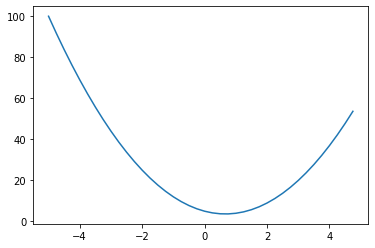

In [8]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)

plt.plot(xs, ys)

In [9]:
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
print(d)

4.0


In [10]:
h = 0.00001

a = 2.0 
b = -3.0
c = 10.0
d1 = a * b + c

a += h
d2 = a * b + c

In [11]:
d1, d2, (d2-d1)/h

(4.0, 3.9999699999999994, -3.000000000064062)

In [216]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - out.data ** 2) * out.grad
        
        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other
    def __rmul__(self, other): # other * self
        return self * other
    def __neg__(self): # -self
        return self * -1
    def __sub__(self, other): # self - other
        return self + (-other)

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
        
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10, label='c')
e = a * b; e.label='e'
d = e + c; d.label='d'

f = Value(-2.0, label='f')
L = d * f; L.label='L'

# a.__mul__(b).__add__(c)

In [71]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

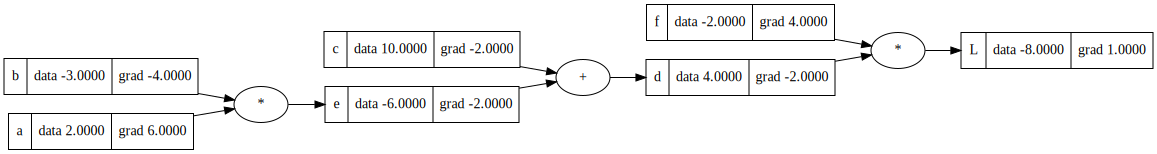

In [79]:
draw_dot(L)

In [78]:
L.grad = 1.0

d.grad = f.data
f.grad = d.data

e.grad = d.grad
c.grad = d.grad

a.grad = e.grad * b.data
b.grad = e.grad * a.data

In [ ]:
L = d * f

dL/dd = f
dL/df = d

d = c + e
dd/de = 1

dL/de = dL/dd * dd/de

e = a * b
dL/da = dL/dd * dd/de * de/da = dL/de * de/da = dL/de * b

In [80]:
lr = 0.01

a.data += lr * a.grad
b.data += lr * b.grad
c.data += lr * c.grad
f.data += lr * f.grad

e = a*b
d = e+c
L = d*f

print(L.data)

-7.286496


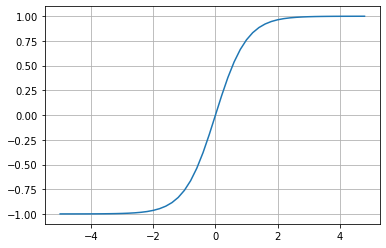

In [81]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();


In [123]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

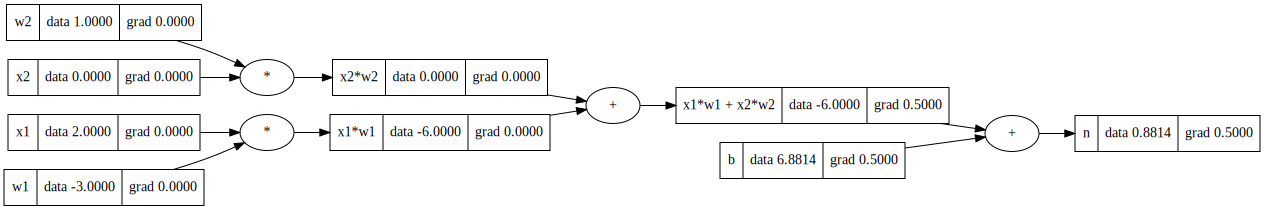

In [108]:
draw_dot(n)

In [124]:
o = n.tanh(); o.label = 'o'

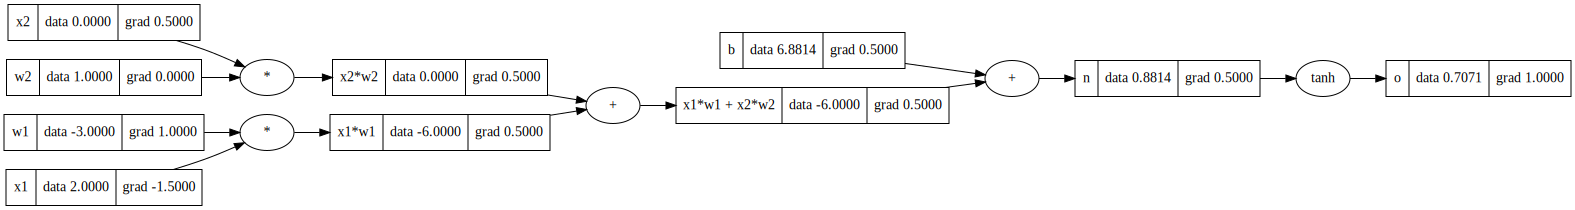

In [127]:
draw_dot(o)

In [126]:
o.backward()

In [97]:
o.grad = 1.0

n.grad = 1 - o.data ** 2
x1w1x2w2.grad = n.grad
b.grad = n.grad

x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad

x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad


In [ ]:
o = tanh(n)
do/dn = 1 - tanh(n)^2 = 1 - o^2 

do/dx1w1+x2w2 = do/dn * dn/dx1w1+x2w2 = do/dn

In [105]:
o.grad = 1.0
o._backward()

In [107]:
n._backward()

In [110]:
b._backward()

In [112]:
x1w1x2w2._backward()

In [114]:
x1w1._backward()
x2w2._backward()

x1._backward()
w1._backward()

x2._backward()
w2._backward()

In [130]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=6.881373587019543),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [131]:
o.grad = 1.0

topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)

for node in reversed(topo):
    node._backward()

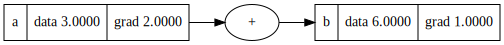

In [145]:
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

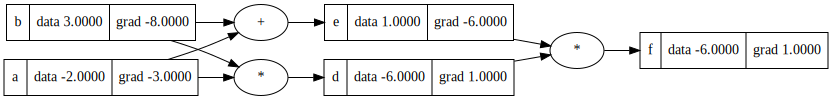

In [146]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

In [147]:
import torch

In [149]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [217]:
class Neuron:
  
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]


In [218]:
x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(data=-0.9670789809832819)

In [219]:
class Layer:
  
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

In [220]:
x = [2.0, 3.0]
n = Layer(2, 3)
n(x)

[Value(data=0.8996841001085992),
 Value(data=-0.9997924015270759),
 Value(data=0.27277155613476584)]

In [221]:
class MLP:
  
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [286]:
x = [2.0, 3.0, -1]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.6839952293992506)

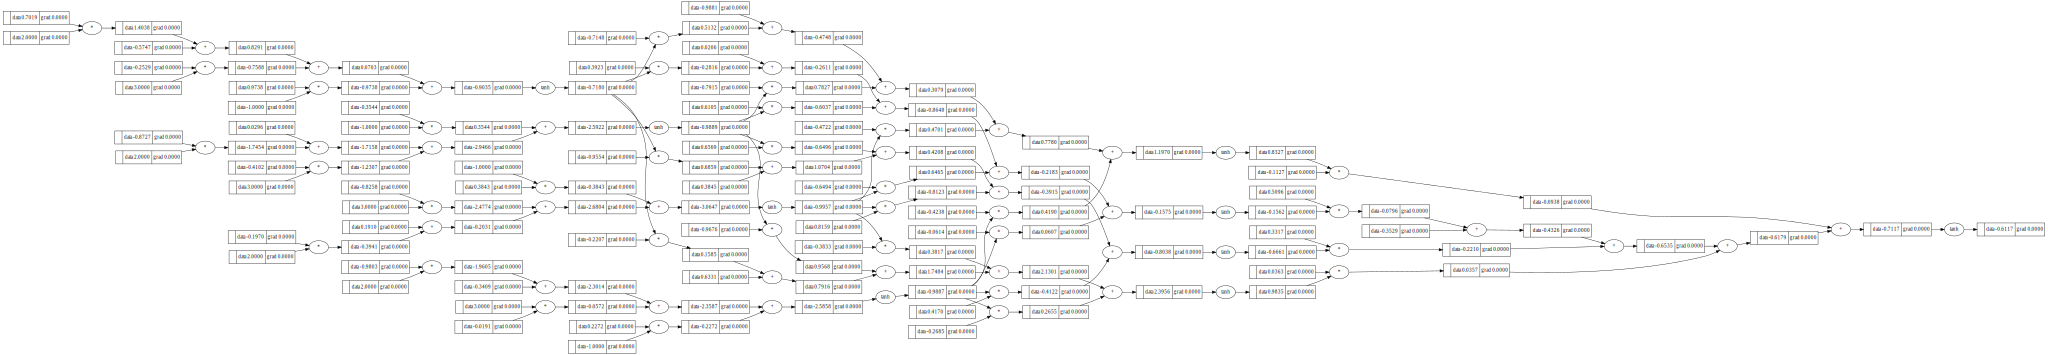

In [223]:
draw_dot(n(x))

In [287]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [398]:
ypred = [n(x) for x in xs]
ypred

[Value(data=0.9443343360239506),
 Value(data=-0.8454944658022037),
 Value(data=-0.9382548682539552),
 Value(data=0.9475564525950483)]

In [399]:
loss = sum((yout - ygt) * (yout - ygt) for ygt, yout in zip(ys, ypred))

In [400]:
loss

Value(data=0.033533413202392705)

In [401]:
# draw_dot(loss)

In [402]:
for p in n.parameters():
    p.grad = 0
loss.backward()

In [403]:
for p in n.parameters():
    p.data = p.data - 0.01 * p.grad

In [404]:
for k in range(20):
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt) * (yout - ygt) for ygt, yout in zip(ys, ypred))
    
    for p in n.parameters():
        p.grad = 0
    loss.backward()
    
    for p in n.parameters():
        p.data = p.data - 0.01 * p.grad
    
    print(k, loss.data)

0 0.03315666288843919
1 0.03279087340638737
2 0.032435565419592964
3 0.03209028651905905
4 0.03175460938942842
5 0.03142813012144895
6 0.031110466657524073
7 0.030801257358334375
8 0.03050015967973634
9 0.03020684895022302
10 0.029921017240194976
11 0.029642372315146458
12 0.029370636665631937
13 0.0291055466075636
14 0.028846851446997838
15 0.028594312704114132
16 0.028347703391580614
17 0.02810680734293711
18 0.027871418587024435
19 0.027641340764840525


In [406]:
ypred

[Value(data=0.9431518159390943),
 Value(data=-0.8642554745709071),
 Value(data=-0.9443362954361542),
 Value(data=0.9462915226051124)]